In [39]:
% load_ext autoreload
% autoreload 2
% matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
np.set_printoptions(precision=5, linewidth=120)
from tqdm import *
from drift_qec.A import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# This is the method using a wobbling operator

In [40]:
def get_PB(d):
    theta1 = np.linspace(0.0, np.pi, 201)
    Ntheta = np.floor(len(theta1)*np.sin(theta1) + 1).astype(np.int)
    theta2 = []
    for ntheta in Ntheta:
        theta2 = theta2 + list(np.linspace(-np.pi, np.pi, ntheta))
    theta2 = np.r_[theta2]
    theta1 = np.repeat(theta1, Ntheta)
    a = np.sin(theta1) * np.cos(theta2)
    b = np.sin(theta1) * np.sin(theta2)
    c = np.cos(theta1)
    B = np.c_[a, b, c]
    
    p1L1 = (B[:, 0] * np.cos(d) - B[:, 1] * np.sin(d)) ** 2
    p2L1 = (B[:, 0] * np.sin(d) + B[:, 1] * np.cos(d)) ** 2
    p3L1 = B[:, 2] ** 2
    p1L2 = (B[:, 0] * np.cos(d) - B[:, 2] * np.sin(d)) ** 2
    p2L2 = B[:, 1] ** 2
    p3L2 = (B[:, 0] * np.sin(d) + B[:, 2] * np.cos(d)) ** 2
    p1L3 = B[:, 0] ** 2
    p2L3 = (B[:, 1] * np.cos(d) - B[:, 2] * np.sin(d)) ** 2
    p3L3 = (B[:, 1] * np.sin(d) + B[:, 2] * np.cos(d)) ** 2
    P = np.log(np.c_[p1L1, p2L1, p3L1, p1L2, p2L2, p3L2, p1L3, p2L3, p3L3])
    
    priorB = np.ones(len(B))
    
    return P, B, priorB

def update_prior(x, P, priorB):
    update = np.dot(data, P.T)
    sel_not_nan = ~np.isnan(priorB)
    sel_not_inf = np.isfinite(priorB)
    priorB_mean = np.mean(priorB[sel_not_nan & sel_not_inf])
    return priorB + update - priorB_mean

def reconstruct_M(B, priorB):
    idx = np.nanargmax(priorB)
    M = np.outer(B[idx, :], B[idx, :])
    return M

In [41]:
TRIALS = 100
RECORDS = []

for trial in tqdm(range(TRIALS)):
    d = 0.25*np.pi
    channel = Channel(kx=0.99998, ky=0.00001, kz=0.00001, Q=FIXEDQ, n=1, d1=d, d2=d, d3=d)
    P, B, priorB = get_PB(d)
    for t in range(1000):
        data = channel.sample_data()
        priorB = update_prior(data, P, priorB)
        M = reconstruct_M(B, priorB)
        channel.M = np.dot(np.dot(channel.Qc.T, M), channel.Qc)
        Qhat = np.linalg.svd(channel.M)[0]
        Q = channel.Q
        RECORDS.append({
                "t": channel.n * t,
                "q_qhat": np.linalg.norm(Qhat[:, 0] - Q[:, 0])
            })

df = pd.DataFrame(RECORDS)
df.to_csv("TwoAngleBayes200.csv")

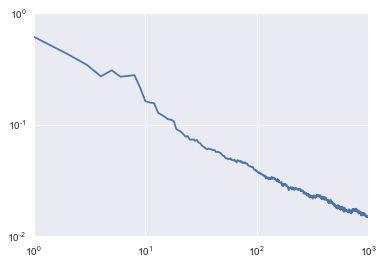

In [42]:
v = df.groupby("t").mean()
plt.loglog(v.index.values, v["q_qhat"].values)

In [43]:
print channel.M
print channel.C

[[ 0.03636  0.16297 -0.09209]
 [ 0.16297  0.7304  -0.41274]
 [-0.09209 -0.41274  0.23323]]
[[ 0.03653  0.16333 -0.09222]
 [ 0.16333  0.7305  -0.41247]
 [-0.09222 -0.41247  0.23291]]


# We actually don't need a wobbling operator since for a two parameter family of channels, the diagonal statistics are good enough.

In [130]:
C_DIAGS = np.diag([0.99998, 0.00001, 0.00001])
C_BASIS = FIXEDQ
C = np.dot(np.dot(C_BASIS, C_DIAGS), C_BASIS.T)

CONTROL_Q = np.linalg.qr(np.random.randn(3,3))[0]
CONTROL_Q = np.eye(3)
CONTROL_C = np.dot(np.dot(CONTROL_Q, C), CONTROL_Q)

theta1 = np.linspace(0.0, np.pi, 201)
Ntheta = np.floor(len(theta1)*np.sin(theta1) + 1).astype(np.int)
theta2 = []
for ntheta in Ntheta:
    theta2 = theta2 + list(np.linspace(-np.pi, np.pi, ntheta))
theta2 = np.r_[theta2]
theta1 = np.repeat(theta1, Ntheta)

Screw the adaptive part for a sec, just get the learning rate:

In [143]:
TRIALS = 100
RECORDS = []
for trial in tqdm(range(TRIALS)):

    prior = np.ones(len(theta2)) / float(len(theta2))

    update = {}
    update["x"] = (np.sin(theta1) * np.cos(theta2)) ** 2
    update["y"] = (np.sin(theta1) * np.sin(theta2)) ** 2
    update["z"] = np.cos(theta1) ** 2

    rates = np.diag(CONTROL_C) / np.trace(CONTROL_C)

    for t in range(1000):
        err = np.random.choice(["x", "y", "z"], p=rates)
        prior = prior  * update[err]
        prior = prior / np.sum(prior)
        idx = np.argmax(prior)
        opttheta1 = theta1[idx]
        opttheta2 = theta2[idx]
        optqx = np.array([np.sin(opttheta1) * np.cos(opttheta2),
                          np.sin(opttheta1) * np.sin(opttheta2),
                          np.cos(opttheta1)])
        Mhat = np.outer(optqx, optqx)
        RECORDS.append({
                "t": t,
                "unsigned_err": np.linalg.norm(np.abs(np.abs(Mhat) - np.abs(C))),
                "signed_err": np.linalg.norm(Mhat - C)
            })
df = pd.DataFrame(RECORDS)

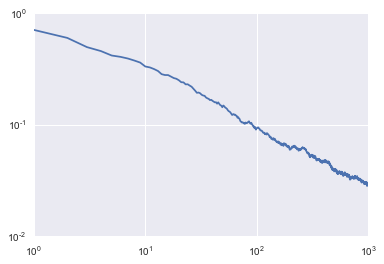

In [146]:
v = df.groupby("t").mean()
plt.loglog(v.index.values, v["unsigned_err"].values)

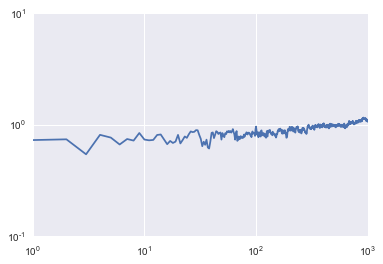

In [147]:
v = df.groupby("t").mean()
plt.loglog(v.index.values, v["signed_err"].values)